In [22]:
from __future__ import unicode_literals
# Import the required libraires
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt

%matplotlib inline

import re
import unicodedata

# Pre-processing library
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import nltk
import gensim
!pip install Arabic-Stopwords
import arabicstopwords.arabicstopwords as stp
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
import pyarabic.araby as araby
from nltk.stem.isri import ISRIStemmer

import unicodedata
!pip install unidecode
from unidecode import unidecode
!pip install emoji
import emoji

# Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
from gensim.models import FastText

# Mectrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc


# Models 
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


test_neg = pd.read_csv('./data/test_Arabic_tweets_negative.tsv',header=None, sep='\t')
test_pos = pd.read_csv('./data/test_Arabic_tweets_positive.tsv',header=None, sep='\t')
train_neg = pd.read_csv('./data/train_Arabic_tweets_negative.tsv',header=None, sep='\t')
train_pos = pd.read_csv('./data/train_Arabic_tweets_positive.tsv',header=None, sep='\t')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.8 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=95798a6ba9d2680899fb88c9e8df3a853e6bca84e5f9dcf0db7a6573d8a4e245
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji


In [155]:
class ml_model():

    def __init__(self,  model='xgboost',vectorizer='tfidf'):
        
        self.vectorizer_type = vectorizer    
        if vectorizer == 'tfidf':
            self.vectorizer = TfidfVectorizer()
        elif vectorizer == 'word2vec':
            self.vectorizer = gensim.models.Word2Vec()
        elif vectorizer == 'fasttext':
          self.vectorizer = FastText()
            
        self.model_type = model
        if model == 'xgboost':
            self.model = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.9, subsample=0.7,learning_rate=0.08)
        elif model == 'svm':
            self.model = svm.SVC(class_weight='balanced')
        elif model == 'rfc':
            self.model = RandomForestClassifier(class_weight='balanced')
        elif model == 'nb':
            self.model = GaussianNB()
        elif model == 'lr':
            self.model = LogisticRegression(max_iter=300)
            
#         self.pipeline = Pipeline([ ('vectorizer', self.vectorizer), ('model',self.model)]) 

        
        self.stopwords = set(stp.stopwords_list())
        self.emojis_ar = {}
        with open('emojis.csv','r',encoding='utf-8') as f:
            lines = f.readlines()
            
            for line in lines:
                line = line.strip('\n').split(';')
                self.emojis_ar.update({line[0].strip():line[1].strip()})
              
          
        
        
    def load_data(self, df):
        self.df = df.copy()
    
    def clean_review(self, text):
            
        text = re.sub("[إأٱآا]", "ا", text)
        text = re.sub("ى", "ي", text)
        text = re.sub("ؤ", "ء", text)
        text = re.sub("ئ", "ء", text)
        text = re.sub("ة", "ه", text)
        noise = re.compile(""" ّ    | # Tashdid
                                َ    | # Fatha
                                ً    | # Tanwin Fath
                                ُ    | # Damma
                                ٌ    | # Tanwin Damm
                                ِ    | # Kasra
                                ٍ    | # Tanwin Kasr
                                ْ    | # Sukun
                                ـ     # Tatwil/Kashida
                            """, re.VERBOSE)
        text = re.sub(noise, '', text)
        text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
        text = word_tokenize(text)
        # text = " ".join(ISRIStemmer().stem(i) for i in text if i not in self.stopwords)
        text = " ".join(WordNetLemmatizer().lemmatize(i) for i in text if i not in self.stopwords)
    
        return text

        

    def remove_emoji(self, text):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)
        return text



    def emoji_native_translation(self, text):
      if not text:
        return text
      loves = ["<3", "♥",'❤']
      smilefaces = []
      sadfaces = []
      neutralfaces = []

      eyes = ["8",":","=",";"]
      nose = ["'","`","-",r"\\"]
      for e in eyes:
          for n in nose:
              for s in ["\)", "d", "]", "}","p"]:
                  smilefaces.append(e+n+s)
                  smilefaces.append(e+s)
              for s in ["\(", "\[", "{"]:
                  sadfaces.append(e+n+s)
                  sadfaces.append(e+s)
              for s in ["\|", "\/", r"\\"]:
                  neutralfaces.append(e+n+s)
                  neutralfaces.append(e+s)
              #reversed
              for s in ["\(", "\[", "{"]:
                  smilefaces.append(s+n+e)
                  smilefaces.append(s+e)
              for s in ["\)", "\]", "}"]:
                  sadfaces.append(s+n+e)
                  sadfaces.append(s+e)
              for s in ["\|", "\/", r"\\"]:
                  neutralfaces.append(s+n+e)
                  neutralfaces.append(s+e)

      smilefaces = list(set(smilefaces))
      sadfaces = list(set(sadfaces))
      neutralfaces = list(set(neutralfaces))
      t = []

      for w in text.split():
          if w in loves:
              t.append("حب")
          elif w in smilefaces:
              t.append("مضحك")
          elif w in neutralfaces:
              t.append("عادي")
          elif w in sadfaces:
              t.append("محزن")
          else:
              t.append(w)
      newText = " ".join(t)
      return newText

    def is_emoji(self, word):
        if word in self.emojis_ar:
            return True
        else:
            return False
    
    def add_space(self, text):
        return ''.join(' ' + char if self.is_emoji(char) else char for char in text).strip()

    !pip install aiogoogletrans
    !pip install asyncio
    from aiogoogletrans import Translator
    translator = Translator()
    import asyncio
    loop = asyncio.get_event_loop()

    def translate_emojis(self, words):
        word_list = list()
        words_to_translate = list()
        for word in words :
            t = self.emojis_ar.get(word.get('emoji'),None)
            if t is None:
                word.update({'translation':'عادي','translated':True})
                #words_to_translate.append('normal')
            else:
                word.update({'translated':False,'translation':t})
                words_to_translate.append(t.replace(':','').replace('_',' '))
            word_list.append(word)
        return word_list

    def emoji_unicode_translation(self, text):
        if not text:
          return text
        text = self.add_space(text)
        words = text.split()
        text_list = list()
        emojis_list = list()
        c = 0
        for word in words:
            if self.is_emoji(word):
                emojis_list.append({'emoji':word,'emplacement':c})
            else:
                text_list.append(word)
            c+=1
        emojis_translated = self.translate_emojis(emojis_list)
        for em in emojis_translated:
            text_list.insert(em.get('emplacement'),em.get('translation'))
        text = " ".join(text_list)
        return text
        
    def clean_emoji(self, text):
        text = self.emoji_native_translation(text)
        text = self.emoji_unicode_translation(text)
        return text



    def preprocess(self, x):
        x = [self.clean_emoji(rev) for rev in x]
        print(x[0:10])
        x = [self.remove_emoji(rev) for rev in x]
        self.data = [self.clean_review(rev) for rev in x]
        
        print(self.data[0:10])
        
        return self.data
    
    def vectorize_data(self, x):
        if self.vectorizer_type == 'tfidf':
            return self.vectorizer.transform(x)
        elif self.vectorizer_type == 'fasttext' or self.vectorizer_type == 'word2vec':
            ft_arr = np.zeros((len(x), 500))
            for i in range(len(x)):
                ft_arr[i,:] = self.wordvec(x[i], 500)

            return ft_arr

    def wordvec(self, x, size):
        vec = np.zeros(size).reshape((1, size))
        count = 0.
        for word in x:
            try:
                vec += self.vectorizer[word].reshape((1, size))
                count += 1.
            except KeyError: # handling the case where the token is not in vocabulary
                            
                continue
        if count != 0:
            vec /= count
        return vec
        
        
    def train(self, x, y):
        x = self.preprocess(x)
        
        if self.vectorizer_type == 'tfidf':
            self.vectorizer.fit_transform(x)
        elif self.vectorizer_type == 'fasttext':
            self.vectorizer = FastText(sentences=x, size= 500)
        elif self.vectorizer == 'word2vec':
            self.vectorizer = Word2Vec(sentences = x, size= 500)



        x = self.vectorize_data(x)
        
        if self.model_type == 'nb':
            self.model.fit(x.toarray(),y)
        else:
            self.model.fit(x,y)
        
        
    def score(self, x_test, y_test, show=True):
        x_test = self.preprocess(x_test)
        
        x_test = self.vectorize_data(x_test)
        
        if self.model_type == 'nb':
            y_pred = self.model.predict(x_test.toarray())
        else:
            y_pred = self.model.predict(x_test)
        
        self.f1 = f1_score(y_test, y_pred, average="macro")*100
        self.precision = precision_score(y_test, y_pred, average="macro")*(100)
        self.recall = recall_score(y_test, y_pred, average="macro")*100
        self.accuracy = accuracy_score(y_test, y_pred)*100
        self.auc = roc_auc_score(y_test,y_pred)

        if not show:
          return y_pred

        print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}\n')
        print(f'The F1 score is: {self.f1}')
        print(f'The precision score is: {self.precision}')
        print(f'The recall score is: {self.recall}') 
        print(f'The accuracy score is: {self.accuracy}\n\n\n')
        
        print(f'AUC score is: {self.auc}')
        
        return y_pred
        
    def predict(self, x):
        x = self.clean_review(x)
        
        x = self.vectorize_data([x])
        
        return(self.model.predict(x))
    
    def get_params(self):
        return self.pipeline.get_params()
    
    def draw_roc(self, x, y):
        
        y_pred = self.score(x,y)
        
        clf_fpr, clf_tpr, threshold = roc_curve(y, y_pred)
        auc_clf = auc(clf_fpr, clf_tpr)
        
        plt.figure(figsize=(5, 5), dpi=100)
        plt.plot(clf_fpr, clf_tpr, linestyle='-', label='clf (auc = %0.3f)' % auc_clf)

        plt.xlabel('False Positive Rate -->')
        plt.ylabel('True Positive Rate -->')

        plt.legend()

        plt.show()

    def draw_roc_mult(x, y, models):
        plt.figure(figsize=(5, 5), dpi=100)
        for model in models:
           y_pred = model[0].score(x,y,show=False)
           clf_fpr, clf_tpr, threshold = roc_curve(y, y_pred)
           auc_clf = auc(clf_fpr, clf_tpr)
           
           
           plt.plot(clf_fpr, clf_tpr, linestyle='-', label=f'{model[1]} (auc = %0.3f, f1 = %0.3f)' % (auc_clf,model[0].f1))
        
        plt.xlabel('False Positive Rate -->')
        plt.ylabel('True Positive Rate -->')

        plt.legend()

        plt.show()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [156]:
test_df = pd.concat([test_neg,test_pos], ignore_index=True)
test_df.head()

train_df = pd.concat([train_neg, train_pos], ignore_index=True)
train_df.head()

,0,1
0,neg,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم...
1,neg,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...
2,neg,#الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال و...
3,neg,نعمة المضادات الحيوية . تضع قطرة💧مضاد بنسلين ع...
4,neg,الدودو جايه تكمل علي 💔


In [157]:
test_df[0][test_df[0] == 'neg'] = 0
test_df[0][test_df[0] == 'pos'] = 1

train_df[0][train_df[0] == 'neg'] = 0
train_df[0][train_df[0] == 'pos'] = 1

In [158]:
types_dict = { 0: bool}
test_df = test_df.astype(types_dict)
train_df = train_df.astype(types_dict)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45275 entries, 0 to 45274
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       45275 non-null  bool  
 1   1       45275 non-null  object
dtypes: bool(1), object(1)
memory usage: 398.0+ KB


In [159]:
train_df.columns = ['feedback', 'review']
test_df.columns = ['feedback', 'review']

In [160]:
train_df = shuffle(train_df)
test_df = shuffle(test_df)

valid_df = pd.DataFrame()
print(train_df.shape, valid_df.shape)
_, valid_df['review'], _, valid_df['feedback'] = train_test_split(train_df['review'],train_df['feedback'],test_size=0.2,random_state=42)


valid_df.shape, train_df.shape


(45275, 2) (0, 0)


((9055, 2), (45275, 2))

In [161]:
print(train_df['feedback'].value_counts())
print(test_df['feedback'].value_counts())

True     22761
False    22514
Name: feedback, dtype: int64
False    5768
True     5752
Name: feedback, dtype: int64


In [162]:
print(valid_df['review'].head(10))

16740    لما جيش والد فراي عزفوا " أمطار كاستيمير " فجأ...
19655                             يالدب هذا رجال مهب بنت 🌚
8141     ⠀ ⠀ ⠀ ⠀ كذبت لآقلت خوته تسآوي ملآيين صآحبي ذآ ...
42799             اقتنعت ان فزة قلبي ل اسمك مستحيل تتغير 💛
148      ٲليس من العيب ان تحفظ كل الأغاني .. وتكرر نفس ...
11687                                   سمعا و طاعة سيدي ✋
16355     يارب احس بذا الشعور قريب ويكون تعبي من الوظيفه 😔
7485     تلاتين سنة بترقص .. الليلة رقصتنا أنا ببكي 😭 د...
4339     بس أنا خلاص أكره أسوي شيء ولا صرت بأسوي شيء أح...
20391    مع بدء العد التنازلي ل #رمضان، يجب أن نتفطن لل...
Name: review, dtype: object


In [163]:
xg_ft = ml_model('xgboost',vectorizer='fasttext')
rfc_ft = ml_model('rfc', vectorizer='fasttext')
rfc_tf = ml_model('rfc', vectorizer='tfidf')
svm_tf = ml_model('svm',vectorizer='tfidf')

In [164]:
xg_ft.train(train_df['review'], train_df['feedback'])
rfc_ft.train(train_df['review'], train_df['feedback'])
rfc_tf.train(train_df['review'], train_df['feedback'])
svm_tf.train(train_df['review'], train_df['feedback'])

['صنوف الأنام بالتعاشر تعرف أمعدن أصيل شخصها أم مزيف فكم من جميل أبهر الناس حسنه وأفعاله…', '#احباب_هاني_للدعم ارتفع اوراق اشجار الساعه :00am صباحا تم تجديد الرصيد لكل الأعضاء كالتالي خسارة نقطة السهم للاسفل السهم للاسفل 🔴عدد تغريدات بدون تاق باليوم…', 'طبعا حنا ما شي حلنا متأمل', 'حلمت ان الاتحاد فاز على النصر - المرهق', 'تمنيت ان اعيش كما تريد نفسي ولكن عاشت نفسي كما يريد زماني تنهد', 'الى جهنم ي بيريز ، تسيف حالنا تسذا نحلل يحيى الشهري والمولد ، كان الحين نخطط ع يوم الثلاثاء بالابطال قلب مجروح', 'الاختبار بكرا و لا فتحت الكتاب و بطني يغلي غلي و الله اخاف اروح مستشفى و يروح اليوم كله هناك مرتبك', 'ليست كل محاولات العبور تعني التجاوز .. قلب مجروح', '#Tellnoym توني اتوقع ,ليه ؟ :)', 'فرش لزميلته السرير ورد وضحك عليها ونكها: دياثه مكوة كس زغب ديوث انتصار إبريل :18:28 صباحا']


['صنوف الانام بالتعاشر تعرف امعدن اصيل شخصها ام مزيف جميل ابهر الناس حسنه وافعاله…', '# احباب_هاني_للدعم ارتفع اوراق اشجار الساعه :00am صباحا تم تجديد الرصيد الاعضاء كالتالي خساره نقطه السهم للاسفل السهم للاسفل عدد تغريدات تاق باليوم…', 'طبعا حنا شي حلنا متامل', 'حلمت ان الاتحاد فاز النصر - المرهق', 'تمنيت ان اعيش تريد عاشت يريد تنهد', 'الي جهنم بيريز ، تسيف حالنا تسذا نحلل يحيي الشهري والمولد ، الحين نخطط يوم الثلاثاء بالابطال قلب مجروح', 'الاختبار بكرا الكتاب بطني يغلي غلي الله اخاف اروح مستشفي يروح اليوم مرتبك', 'محاولات العبور تعني التجاوز .. قلب مجروح', '# Tellnoym توني اتوقع , ليه ؟ : )', 'فرش لزميلته السرير ورد وضحك ونكها : دياثه مكوه كس زغب ديوث انتصار ابريل :18:28 صباحا']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:217: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


['صنوف الأنام بالتعاشر تعرف أمعدن أصيل شخصها أم مزيف فكم من جميل أبهر الناس حسنه وأفعاله…', '#احباب_هاني_للدعم ارتفع اوراق اشجار الساعه :00am صباحا تم تجديد الرصيد لكل الأعضاء كالتالي خسارة نقطة السهم للاسفل السهم للاسفل 🔴عدد تغريدات بدون تاق باليوم…', 'طبعا حنا ما شي حلنا متأمل', 'حلمت ان الاتحاد فاز على النصر - المرهق', 'تمنيت ان اعيش كما تريد نفسي ولكن عاشت نفسي كما يريد زماني تنهد', 'الى جهنم ي بيريز ، تسيف حالنا تسذا نحلل يحيى الشهري والمولد ، كان الحين نخطط ع يوم الثلاثاء بالابطال قلب مجروح', 'الاختبار بكرا و لا فتحت الكتاب و بطني يغلي غلي و الله اخاف اروح مستشفى و يروح اليوم كله هناك مرتبك', 'ليست كل محاولات العبور تعني التجاوز .. قلب مجروح', '#Tellnoym توني اتوقع ,ليه ؟ :)', 'فرش لزميلته السرير ورد وضحك عليها ونكها: دياثه مكوة كس زغب ديوث انتصار إبريل :18:28 صباحا']


['صنوف الانام بالتعاشر تعرف امعدن اصيل شخصها ام مزيف جميل ابهر الناس حسنه وافعاله…', '# احباب_هاني_للدعم ارتفع اوراق اشجار الساعه :00am صباحا تم تجديد الرصيد الاعضاء كالتالي خساره نقطه السهم للاسفل السهم للاسفل عدد تغريدات تاق باليوم…', 'طبعا حنا شي حلنا متامل', 'حلمت ان الاتحاد فاز النصر - المرهق', 'تمنيت ان اعيش تريد عاشت يريد تنهد', 'الي جهنم بيريز ، تسيف حالنا تسذا نحلل يحيي الشهري والمولد ، الحين نخطط يوم الثلاثاء بالابطال قلب مجروح', 'الاختبار بكرا الكتاب بطني يغلي غلي الله اخاف اروح مستشفي يروح اليوم مرتبك', 'محاولات العبور تعني التجاوز .. قلب مجروح', '# Tellnoym توني اتوقع , ليه ؟ : )', 'فرش لزميلته السرير ورد وضحك ونكها : دياثه مكوه كس زغب ديوث انتصار ابريل :18:28 صباحا']
['صنوف الأنام بالتعاشر تعرف أمعدن أصيل شخصها أم مزيف فكم من جميل أبهر الناس حسنه وأفعاله…', '#احباب_هاني_للدعم ارتفع اوراق اشجار الساعه :00am صباحا تم تجديد الرصيد لكل الأعضاء كالتالي خسارة نقطة السهم للاسفل السهم للاسفل 🔴عدد تغريدات بدون تاق باليوم…', 'طبعا حنا ما شي حلنا متأمل', 'حلمت ان الاتحاد فاز على الن

In [168]:
# xg_ft.score(test_df['review'],test_df['feedback'])
# rfc_ft.score(test_df['review'],test_df['feedback'])
# rfc_tf.score(test_df['review'],test_df['feedback'])
# svm_tf.score(test_df['review'],test_df['feedback'])

# xg_ft.draw_roc(test_df['review'],test_df['feedback'])
# rfc_ft.draw_roc(test_df['review'],test_df['feedback'])
# rfc_tf.draw_roc(test_df['review'],test_df['feedback'])
# svm_tf.draw_roc(test_df['review'],test_df['feedback'])

['من قرأ سورة , الإخلاص عشرة مرات بنى الله له بيتا في الجنه زهرة الكرز #المقابيل_للدعم #مملكة_خالد_الهيلا #اسطول_زعماء_تويتر…', 'بس اناا قلب مجروح', 'جميل أن يظن الناس بك خيرا وأجمل أن تكون خيرا مما يطنون صباحكم سعيد دوار الشمس', 'حس بجمال النعم الصغيرة وافرح بأشيائك البسيطة وقل الحمدلله حمامة السلام #صباح_الخير احمر خدود #رتويت_ابوحضرم', 'اشكركم ولنستمر لتكون مدن المملكه باجمل مايكون باقة أزهار', 'يقول الليل ليس لي ذنب بما يحدث لكم في النهار وتحدثوني به ..ولكن بصمت وعلى وسادة قلب مجروح #وش_يقول_الليل', 'صباح السبت وجه مبتسم قليلا', 'تلاتين سنة بترقص .. الليلة رقصتنا أنا ببكي تنهد دي حلاوة شديدة باخ', 'يعني يمدح اسمك تنهد', '- بتفرق جدا مين سايبك لحد ما تهدى ،، ومين معاك لحد ما تهدى ،، ومين اللي بيهديك ،، قلب ازرق']
['قرا سوره , الاخلاص عشره مرات بني الله بيتا الجنه زهره الكرز # المقابيل_للدعم # مملكه_خالد_الهيلا # اسطول_زعماء_تويتر…', 'اناا قلب مجروح', 'جميل ان يظن الناس خيرا واجمل ان تكون خيرا يطنون صباحكم سعيد دوار الشمس', 'حس بجمال النعم الصغيره وافرح باشياءك البسيطه وقل الحمدلله ح

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:217: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


['من قرأ سورة , الإخلاص عشرة مرات بنى الله له بيتا في الجنه زهرة الكرز #المقابيل_للدعم #مملكة_خالد_الهيلا #اسطول_زعماء_تويتر…', 'بس اناا قلب مجروح', 'جميل أن يظن الناس بك خيرا وأجمل أن تكون خيرا مما يطنون صباحكم سعيد دوار الشمس', 'حس بجمال النعم الصغيرة وافرح بأشيائك البسيطة وقل الحمدلله حمامة السلام #صباح_الخير احمر خدود #رتويت_ابوحضرم', 'اشكركم ولنستمر لتكون مدن المملكه باجمل مايكون باقة أزهار', 'يقول الليل ليس لي ذنب بما يحدث لكم في النهار وتحدثوني به ..ولكن بصمت وعلى وسادة قلب مجروح #وش_يقول_الليل', 'صباح السبت وجه مبتسم قليلا', 'تلاتين سنة بترقص .. الليلة رقصتنا أنا ببكي تنهد دي حلاوة شديدة باخ', 'يعني يمدح اسمك تنهد', '- بتفرق جدا مين سايبك لحد ما تهدى ،، ومين معاك لحد ما تهدى ،، ومين اللي بيهديك ،، قلب ازرق']
['قرا سوره , الاخلاص عشره مرات بني الله بيتا الجنه زهره الكرز # المقابيل_للدعم # مملكه_خالد_الهيلا # اسطول_زعماء_تويتر…', 'اناا قلب مجروح', 'جميل ان يظن الناس خيرا واجمل ان تكون خيرا يطنون صباحكم سعيد دوار الشمس', 'حس بجمال النعم الصغيره وافرح باشياءك البسيطه وقل الحمدلله ح

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:217: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


['من قرأ سورة , الإخلاص عشرة مرات بنى الله له بيتا في الجنه زهرة الكرز #المقابيل_للدعم #مملكة_خالد_الهيلا #اسطول_زعماء_تويتر…', 'بس اناا قلب مجروح', 'جميل أن يظن الناس بك خيرا وأجمل أن تكون خيرا مما يطنون صباحكم سعيد دوار الشمس', 'حس بجمال النعم الصغيرة وافرح بأشيائك البسيطة وقل الحمدلله حمامة السلام #صباح_الخير احمر خدود #رتويت_ابوحضرم', 'اشكركم ولنستمر لتكون مدن المملكه باجمل مايكون باقة أزهار', 'يقول الليل ليس لي ذنب بما يحدث لكم في النهار وتحدثوني به ..ولكن بصمت وعلى وسادة قلب مجروح #وش_يقول_الليل', 'صباح السبت وجه مبتسم قليلا', 'تلاتين سنة بترقص .. الليلة رقصتنا أنا ببكي تنهد دي حلاوة شديدة باخ', 'يعني يمدح اسمك تنهد', '- بتفرق جدا مين سايبك لحد ما تهدى ،، ومين معاك لحد ما تهدى ،، ومين اللي بيهديك ،، قلب ازرق']
['قرا سوره , الاخلاص عشره مرات بني الله بيتا الجنه زهره الكرز # المقابيل_للدعم # مملكه_خالد_الهيلا # اسطول_زعماء_تويتر…', 'اناا قلب مجروح', 'جميل ان يظن الناس خيرا واجمل ان تكون خيرا يطنون صباحكم سعيد دوار الشمس', 'حس بجمال النعم الصغيره وافرح باشياءك البسيطه وقل الحمدلله ح

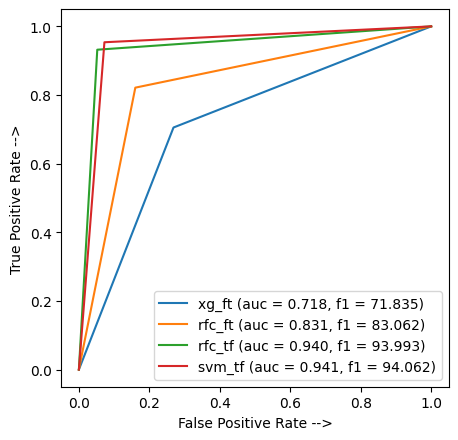

In [167]:
ml_model.draw_roc_mult(test_df['review'],test_df['feedback'], [(xg_ft,'xg_ft'), (rfc_ft,'rfc_ft'), (rfc_tf,'rfc_tf'), (svm_tf,'svm_tf')])